training & result

In [1]:
from fastkaggle import *
import os
import timm
from fastai.vision.all import *
import gc
import os
from matplotlib import pyplot as plt
import cv2
set_seed(42)

In [2]:
comp = 'data'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

In [3]:
path

Path('data')

In [4]:
path.ls()

(#2) [Path('data/test'),Path('data/train')]

In [3]:
trn_path = path/'train'
files = get_image_files(trn_path)

print(trn_path)

data\train


In [6]:
models = {
    'convnext_tiny_in22k': {
        (Resize(480, method='squish'), 224),
    },
}


In [7]:
def find_lr(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64)
    learn = vision_learner(dls, arch, metrics=[error_rate]).to_fp16()
    lr_valley, lr_slide = learn.lr_find(suggest_funcs=(valley, slide))
    
    return lr_valley, lr_slide


--- convnext_tiny_in22k
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


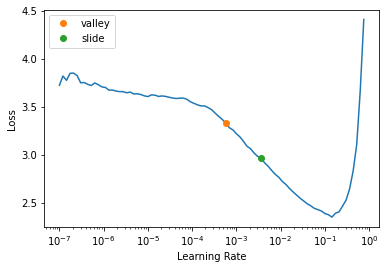

In [8]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        lr_valley, lr_slide = find_lr(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()

In [9]:
def plot_values(recorder, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(recorder.values))), recorder.values[skip_start:], label='train')
        if with_valid:
            idx = (np.array(recorder.iters)<skip_start).sum()
            valid_col = recorder.metric_names.index('valid_accuracy') - 1 
            plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(valid_col), label='valid')
            plt.figure(1)
            plt.legend()

In [10]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=15):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
                                       batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)

    cbs = [GradientAccumulation(64) if accum else [], EarlyStoppingCallback(min_delta=1e-4, patience=10), SaveModelCallback(monitor="valid_loss")]
    learn = vision_learner(dls, arch, metrics=[accuracy, error_rate], cbs=cbs).to_fp16()
    learn.recorder.train_metrics = True
    tst_files = get_image_files(path/'test').sorted()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        learn.recorder.plot_loss()
        learn.recorder.plot_values()
        learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        
        learn.fit_one_cycle(epochs, 0.01)
        learn.recorder.plot_loss()
        learn.recorder.plot_values()

    return learn, dls


In [11]:
torch.cuda.empty_cache()

In [12]:
for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        learn, dls = train(arch, size, item=item, finetune=True, accum=1, epochs=40)
        learn.save(arch+"_no_grad_accum")
        learn.export("models/"+arch+"_no_grad_accum.pkl")

        
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_tiny_in22k
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.156610,0.603898,0.396102,0.719511,0.774038,0.225962,15:21


Better model found at epoch 0 with valid_loss value: 0.7195112109184265.


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 4.00 GiB total capacity; 3.30 GiB already allocated; 0 bytes free; 3.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
models = {
    'convnext_tiny_in22k': {
        (Resize(480, method='squish'), 224),
    },
}

def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.25, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=32//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()

    return learn, dls

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        
        learn, dls = train(arch, size, item=item, finetune=True, accum=4)
    
        gc.collect()
        torch.cuda.empty_cache()


In [ ]:
interpret = ClassificationInterpretation.from_learner(learn)

In [ ]:
interpret.print_classification_report()

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.94      0.97      0.96        66
   bacterial_leaf_streak       0.98      0.98      0.98        59
bacterial_panicle_blight       1.00      1.00      1.00        48
                   blast       0.98      0.99      0.99       312
              brown_spot       0.97      0.99      0.98       153
              dead_heart       1.00      1.00      1.00       218
            downy_mildew       0.97      0.96      0.97       101
                   hispa       0.96      0.96      0.96       233
                  normal       0.98      0.97      0.97       286
                  tungro       0.99      0.97      0.98       188

                accuracy                           0.98      1664
               macro avg       0.98      0.98      0.98      1664
            weighted avg       0.98      0.98      0.98      1664



In [ ]:
interpret.plot_confusion_matrix()

[('normal', 'hispa', 8),
 ('hispa', 'normal', 4),
 ('hispa', 'blast', 3),
 ('blast', 'brown_spot', 2),
 ('tungro', 'downy_mildew', 2),
 ('bacterial_leaf_blight', 'blast', 1),
 ('bacterial_leaf_blight', 'normal', 1),
 ('bacterial_leaf_streak', 'bacterial_leaf_blight', 1),
 ('blast', 'normal', 1),
 ('brown_spot', 'bacterial_leaf_streak', 1),
 ('downy_mildew', 'bacterial_leaf_blight', 1),
 ('downy_mildew', 'blast', 1),
 ('downy_mildew', 'brown_spot', 1),
 ('downy_mildew', 'hispa', 1),
 ('hispa', 'bacterial_leaf_blight', 1),
 ('hispa', 'downy_mildew', 1),
 ('normal', 'brown_spot', 1),
 ('normal', 'tungro', 1),
 ('tungro', 'bacterial_leaf_blight', 1),
 ('tungro', 'blast', 1),
 ('tungro', 'normal', 1)]

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']